In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from pulsedjax.simulate_trace import MakeTrace, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


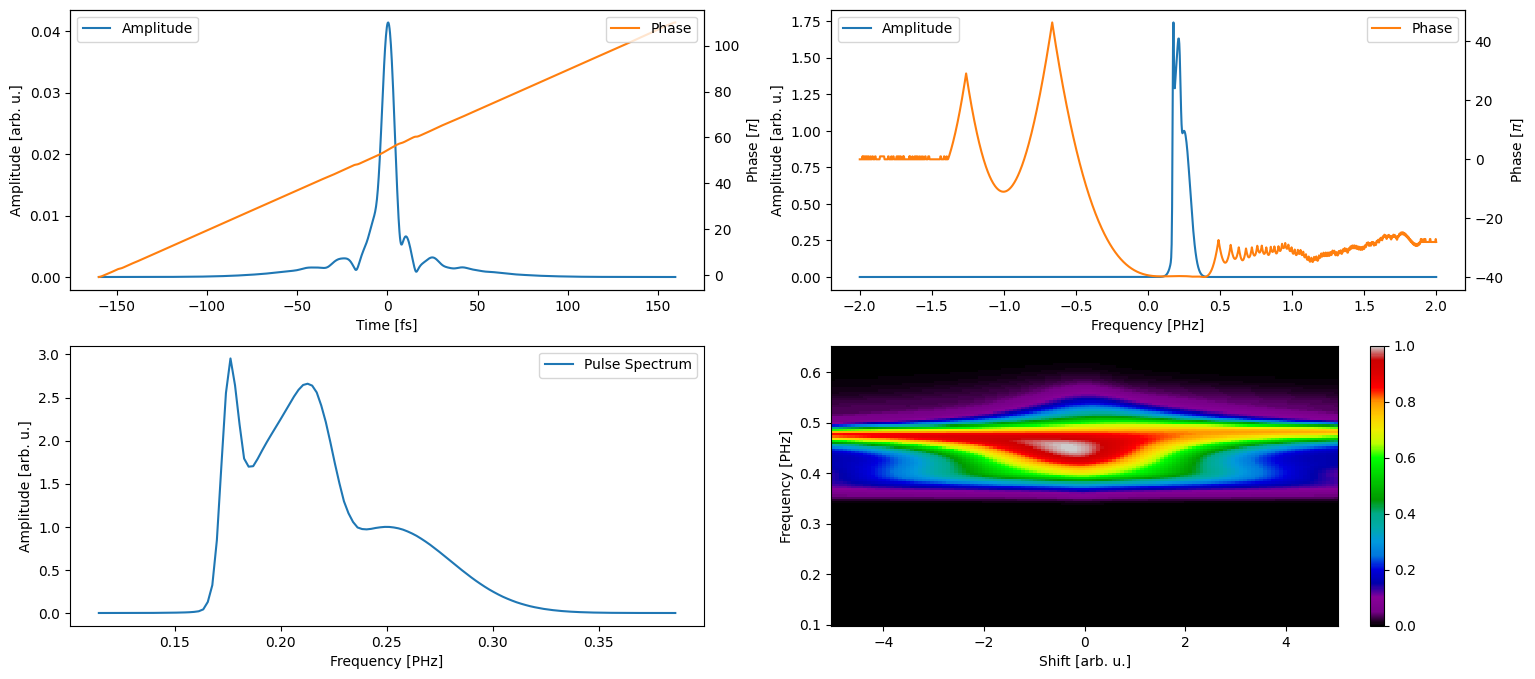

In [1]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, RandomPhase
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1), (0.175,0.2,0.25), (0.01,0.05,0.1), (1,2,1))
phase0 = RandomPhase(number_of_points=4)


mp = MakeTrace(N=128*10, f_max=2)
time, pulse_t, frequency, pulse_f = mp.generate_pulse((amp0,phase0))


import refractiveindex
parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
z_arr = jnp.linspace(-5,5,128) 
z_arr, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "shg", 
                                                               z_arr, phase_type="material", parameters=parameters,
                                                               frequency_range=(0.1,0.65), N=128)


In [ ]:
from pulsedjax.chirp_scan import PtychographicIterativeEngine

copra = PtychographicIterativeEngine(z_arr, frequency_trace, trace, "shg", phase_type="material", 
                                     chirp_parameters=parameters, pie_method=None)

population = copra.create_initial_population(5, "random")

copra.global_newton = "full"
copra.global_adaptive_scaling = "pade_20"

copra.local_gamma = 0.1
copra.global_gamma = 0.1

final_result = copra.run(population, 0, 20)
copra.plot_results(final_result)

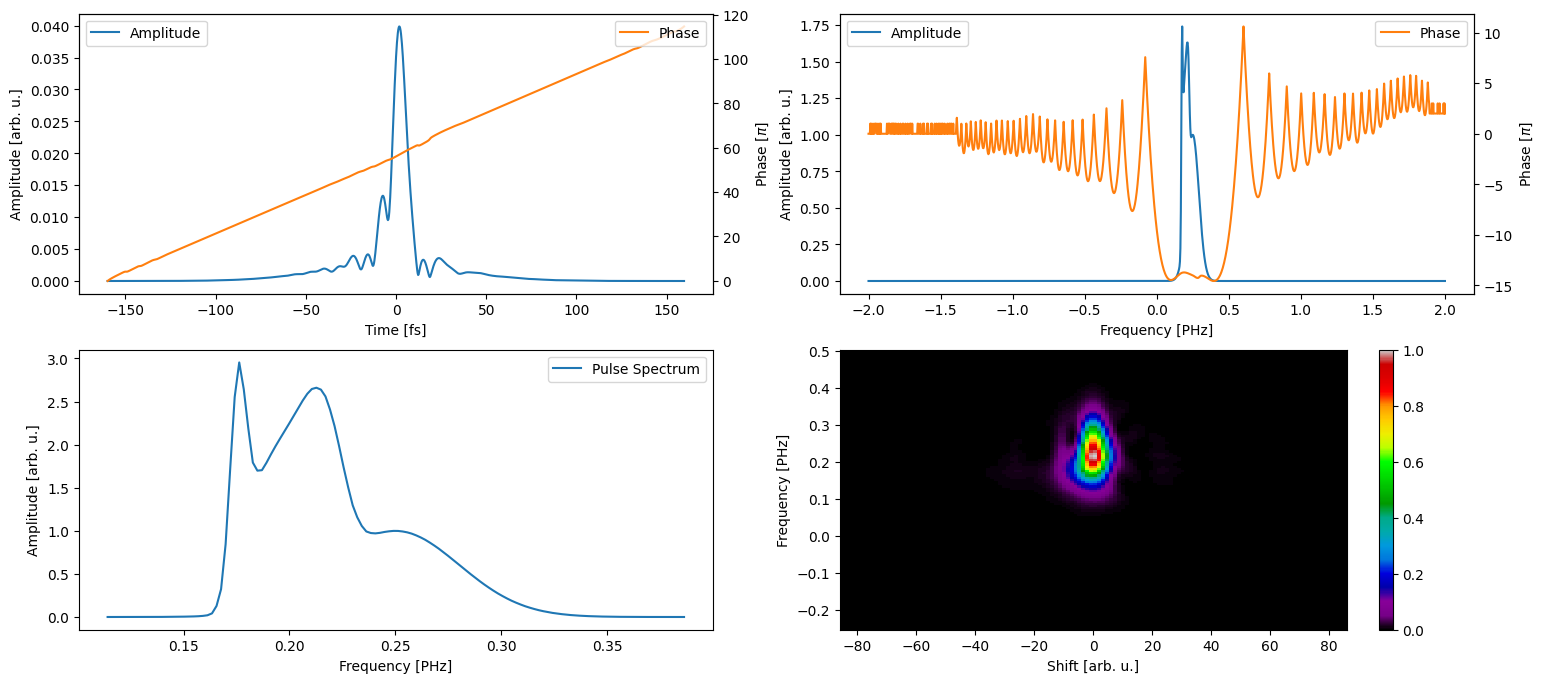

In [1]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, RandomPhase
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1), (0.175,0.2,0.25), (0.01,0.05,0.1), (1,2,1))
phase0 = RandomPhase(number_of_points=4)


mp = MakeTrace(N=128*10, f_max=2)
time, pulse_t, frequency, pulse_f = mp.generate_pulse((amp0,phase0))


delay = jnp.linspace(-150,150,128) 
delay, frequency_trace, trace, spectra = mp.generate_frog(time, frequency, pulse_t, pulse_f, "pg", delay, N=128, interpolate_fft_conform=True, frequency_range=(-0.25,0.5))


In [2]:
from pulsedjax.frog import COPRA

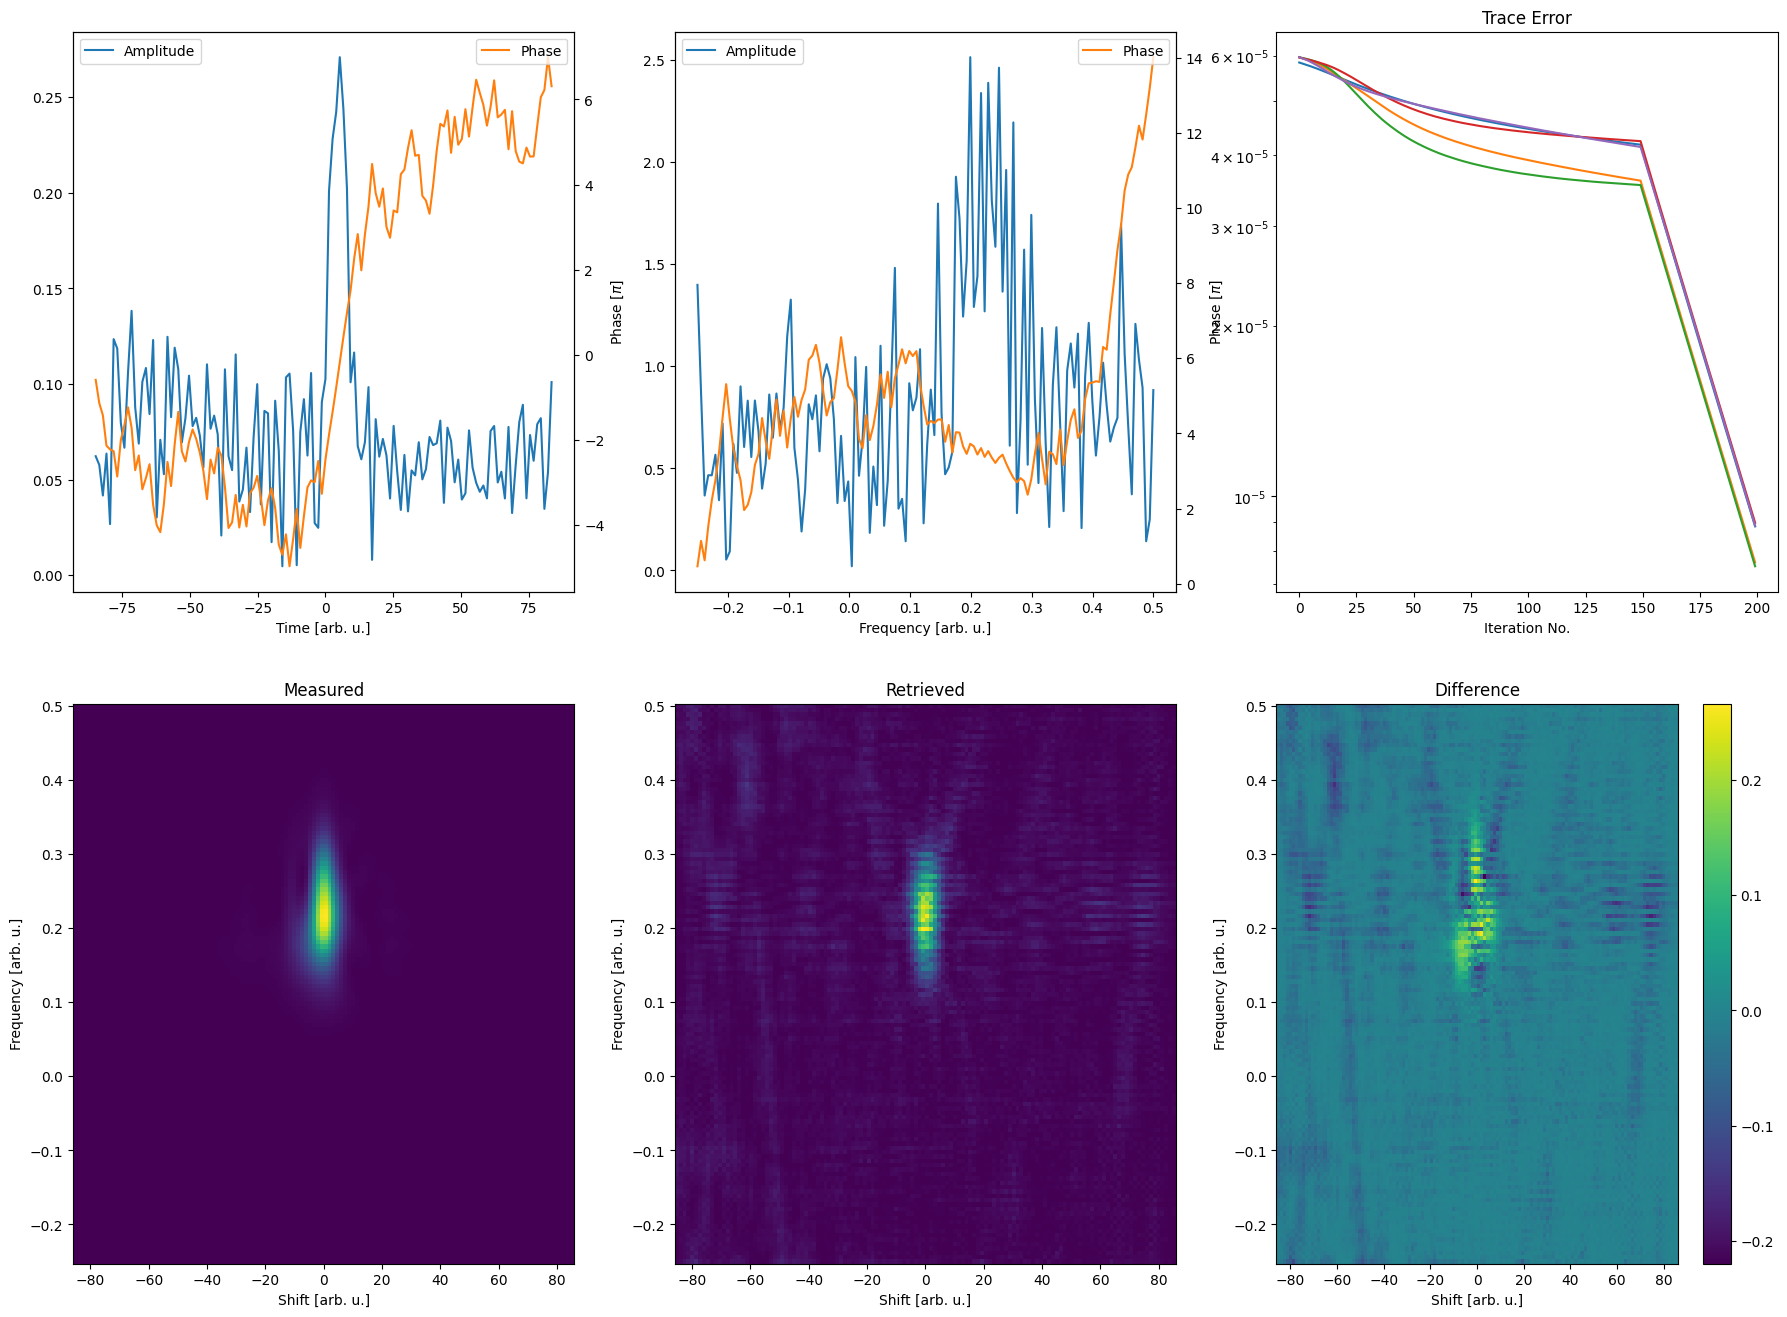

In [17]:
gp = COPRA(delay, frequency_trace, trace, "pg")

population = gp.create_initial_population(5, "random")

gp.local_gamma = 1
gp.global_gamma = 0.25
gp.global_newton = "lbfgs"

final_result = gp.run(population, 150, 50)

gp.plot_results(final_result)

In [4]:
error0 = jnp.copy(final_result.error_arr)

In [6]:
error1 = jnp.copy(final_result.error_arr)

In [8]:
error2 = jnp.copy(final_result.error_arr)

In [19]:
error3 = jnp.copy(final_result.error_arr)

In [10]:
import matplotlib.pyplot as plt

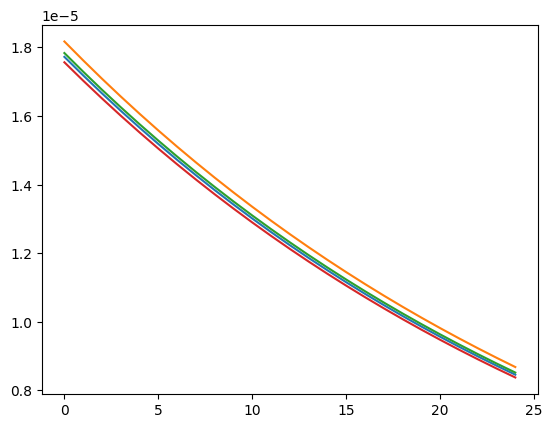

In [21]:
plt.plot(jnp.mean(error0,axis=1)[-25:])
plt.plot(jnp.mean(error1,axis=1)[-25:])
plt.plot(jnp.mean(error2,axis=1)[-25:])
plt.plot(jnp.mean(error3,axis=1)[-25:])